# Obligatorisk innlevering 2 - oppgave 2

I denne oppgaven skal vi forsøke å forutsi oppsigelser ved en arbeidsplass basert på en rekke variabler som f.eks alder, kjønn, utdannelse, lønn, osv.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from scipy.stats import ttest_ind
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [4]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett2.csv")

### Preprosessering:
For å forenkle håndteringen av kategoriske data har jeg her skrevet noe kode som gjør om strenger til intergers

Følgende kolonner er formatert som *object* og inneholder kategoriske variabler i form av strenger

In [6]:
kolonner_obj = df.select_dtypes(include=['object']).columns
print(kolonner_obj)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


I koden under omformer jeg strengene til integers og gir dere "nøkkelen" til å konvertere det tilbake igjen

In [8]:
for i in kolonner_obj:
    print("-----------")
    print(i)
    print("-----------")
    for num, j in enumerate(list(df[i].unique())):
        print("{} = {}".format(j,num))
        df[i].loc[df[i]==j] = num
    df[i] = pd.to_numeric(df[i])

-----------
BusinessTravel
-----------
Travel_Frequently = 0
Travel_Rarely = 1
Non-Travel = 2
-----------
Department
-----------
Research & Development = 0
Sales = 1
Human Resources = 2
-----------
EducationField
-----------
Medical = 0
Other = 1
Marketing = 2
Life Sciences = 3
Technical Degree = 4
Human Resources = 5
-----------
Gender
-----------
Male = 0
Female = 1
-----------
JobRole
-----------
Laboratory Technician = 0
Sales Representative = 1
Sales Executive = 2
Healthcare Representative = 3
Manager = 4
Manufacturing Director = 5
Research Scientist = 6
Human Resources = 7
Research Director = 8
-----------
MaritalStatus
-----------
Married = 0
Divorced = 1
Single = 2
-----------
Over18
-----------
Y = 0
-----------
OverTime
-----------
Yes = 0
No = 1


C:\Users\tobia\AppData\Local\Temp\ipykernel_15904\3482823818.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[i].loc[df[i]==j] = num
C:\Users\tobia\AppData\Local\Temp\ipykernel_15904\3482823818.py:7: SettingWithCopyWarning: 
A value is

I outputen fra koden nedenfor viser datatypen til de forskjellige kolonnene, som nå etter preprosesseringen bare består av integers (int64). 

In [10]:
print(df.dtypes)

id                          int64
Age                         int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesLastYear       int64
WorkLifeBalanc

In [11]:
# Her deler jeg datasettet inn i egenskaper (X) og target (y) (fjerner også den første kolonnen siden det bare er en ID 
# og har dermed ingen prediktiv verdi)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

# PS: Ikke endre denne kodecellen!

#### Oppgave 2.1) 
Visualiser $y\_train$ og $y\_val$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? Begrunn svaret

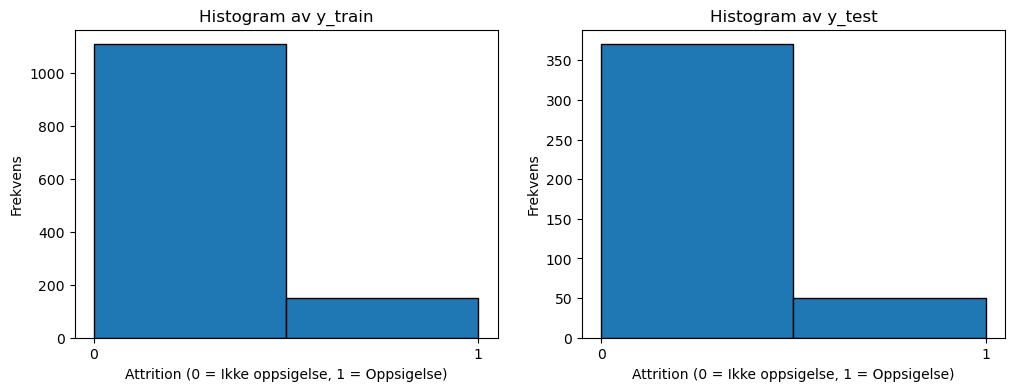

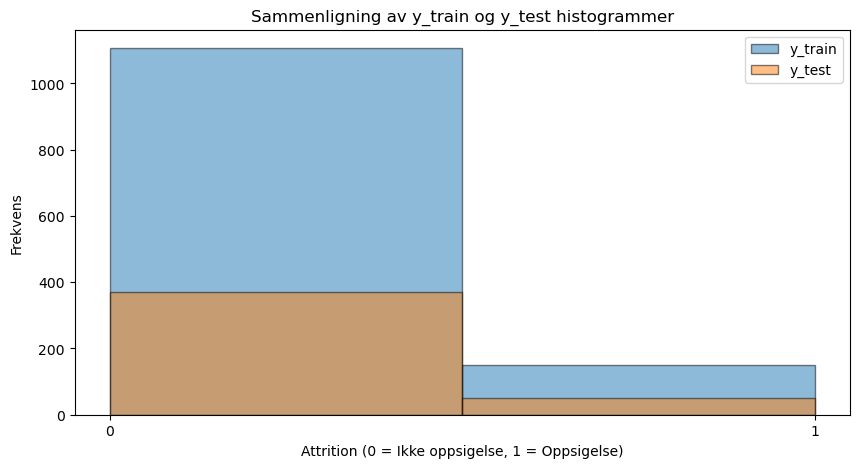

In [13]:
#TODO: visualiser y_train og y_test i et histogram

# Definerer ramme for y_train og y_test visualiseringer
plt.figure(figsize=(12, 4))

# Visualiser y_train (for klassifisering bruker vi bins=2 for binære verdier)
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=2, edgecolor='black')
plt.title("Histogram av y_train")
plt.xlabel("Attrition (0 = Ikke oppsigelse, 1 = Oppsigelse)")
plt.ylabel("Frekvens")
plt.xticks([0, 1])

# Visualiser y_test
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=2, edgecolor='black')
plt.title("Histogram av y_test")
plt.xlabel("Attrition (0 = Ikke oppsigelse, 1 = Oppsigelse)")
plt.ylabel("Frekvens")
plt.xticks([0, 1])

# Viser plott
plt.show()

# Eget plott for å sammenligne y_train og y_test
plt.figure(figsize=(10, 5))
plt.hist(y_train, bins=2, alpha=0.5, label='y_train', edgecolor='black')
plt.hist(y_test, bins=2, alpha=0.5, label='y_test', edgecolor='black')
plt.title("Sammenligning av y_train og y_test histogrammer")
plt.xlabel("Attrition (0 = Ikke oppsigelse, 1 = Oppsigelse)")
plt.ylabel("Frekvens")
plt.xticks([0, 1])
plt.legend()
plt.show()

**Svar:**

Basert på histogrammet ser det ut som vi skal løse et klassifiseringsproblem. De er en tydelig todeling med binære verdier. Et klassifiseringsproblem skiller seg fra regresjonsproblemer ved at vi et ute etter kategoriske utfall og ikke kontinuerlige verdier som vi så i oppgave 1.

#### Oppgave 2.2)
Velg to modeller og gjør repeterte kryssvalideringer $(10)$ med $K=5$
* Velg hvorvidt du vil bruke "default" hyperparamtre for modellene eller om du vil gjøre et hyperparametersøk
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene skriftlig til slutt 


In [16]:
#TODO: repeterte kryssvalideringer for to modeller

# Kjører hyperparametertuning for å finne den beste kombinasjonen av parametere for modellen.    
def hyperparameter_search(X, y, model, param_grid):
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='f1_weighted',
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X, y)
    return grid_search.best_params_, grid_search.best_score_

In [17]:
# Evaluerer og sammenligner to modeller ved hjelp av gjentatt kryssvalidering, beregner F1-score og nøyaktighet, 
# visualiserer resultatene med boksplot, og utfører statistisk testing for å vurdere forskjeller i ytelse.
def evaluate_models(X, y, model1, model2, model1_name, model2_name):
    
    # Oppsett for kryssvalidering
    rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
    
    # Scoringfunksjoner for F1-score og nøyaktighet
    f1_scorer = make_scorer(f1_score, average='weighted')
    accuracy_scorer = make_scorer(accuracy_score)
    
    # Kjører kryssvalidering for begge modellene og printer resultat
    scores = {}
    for name, model in [(model1_name, model1), (model2_name, model2)]:
        scores[name] = {
            'f1': cross_val_score(model, X, y, cv=rkf, scoring=f1_scorer),
            'nøyaktighet': cross_val_score(model, X, y, cv=rkf, scoring=accuracy_scorer)
        }
    
    # Printer gjennomsnittlig F1-score og nøyaktighet for hver modell
    for name in scores:
        print(f"\n{name}:")
        print(f"Average F1-score: {scores[name]['f1'].mean():.3f} ± {scores[name]['f1'].std():.3f}")
        print(f"Average Accuracy: {scores[name]['nøyaktighet'].mean():.3f} ± {scores[name]['nøyaktighet'].std():.3f}")
    
    # Visualiserer F1-score distribusjon for begge modellene med boksplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=[scores[model1_name]['f1'], scores[model2_name]['f1']], palette="Set3")
    plt.xticks([0, 1], [model1_name, model2_name])
    plt.title('F1-scores Distribusjon fra Gjentatt Kryssvalidering')
    plt.ylabel('F1-score')
    plt.show()
    
    # Statistiske tester til sammenligning av modellene
    t_stat, p_value = ttest_ind(scores[model1_name]['f1'], scores[model2_name]['f1'])
    print("\nStatistisk sammenligning:")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Vurderer om det er signifikant forskjell mellom modellene
    if p_value < 0.05:
        better_model = model1_name if scores[model1_name]['f1'].mean() > scores[model2_name]['f1'].mean() else model2_name
        print(f"\nSignifikant forskjell oppdaget (p < 0.05)")
        print(f"{better_model} presterer betraktelig bedre")
    else:
        print("\nIngen signifikant forskjell mellom modellene (p >= 0.05)")

In [18]:
# Lagrer en liste med parameter for hver modell
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# Oppretter instanser for modellene vi skal bruke
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

In [19]:
# Henter optimale parametere
rf_best_params, rf_best_score = hyperparameter_search(X, y, rf_model, rf_params)
gb_best_params, gb_best_score = hyperparameter_search(X, y, gb_model, gb_params)

print("Beste Random Forest Parametere:", rf_best_params)
print("Beste Random Forest Score:", rf_best_score)
print("\nBeste Gradient Boosting Parametere:", gb_best_params)
print("Beste Gradient Boosting Score:", gb_best_score)

Beste Random Forest Parametere: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Beste Random Forest Score: 0.8448321311831528

Beste Gradient Boosting Parametere: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Beste Gradient Boosting Score: 0.8711147684999746



Random Forest:
Average F1-score: 0.842 ± 0.024
Average Accuracy: 0.885 ± 0.016

Gradient Boosting:
Average F1-score: 0.867 ± 0.020
Average Accuracy: 0.886 ± 0.015


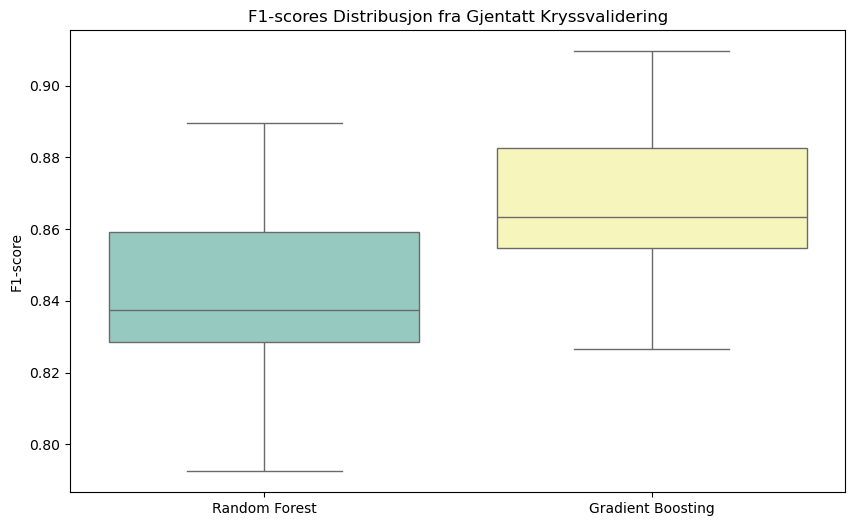


Statistisk sammenligning:
T-statistic: -5.5705
P-value: 0.0000

Signifikant forskjell oppdaget (p < 0.05)
Gradient Boosting presterer betraktelig bedre


In [20]:
# Oppretter optimaliserte modeller ved å bruke de beste parameterne fra hyperparametertuning
rf_optimized = RandomForestClassifier(random_state=42, **rf_best_params)
gb_optimized = GradientBoostingClassifier(random_state=42, **gb_best_params)

# Evaluerer og sammenligner modeller
evaluate_models(X, y, rf_optimized, gb_optimized, 
               "Random Forest", "Gradient Boosting")

**Svar:**

**Beste Modell og Ytelse:**

Ytelsen til Gradient Boosting var bedre med en gjennomsnittlig F1-score på 0.0867 sammenliknet med 0.0842 for Random Forest.

**Statistisk Signifikans:**

T-testen viser oss at det er en signifikant forskjell mellom modellene, som indikerer at Gradient Boosting er bedre enn Random Forest med hensyn til F1-score.


#### Oppgave 2.3) 
Tren de samme modellene men denne gangen med et balansert datasett
* Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen (bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene og sammenlign resultatene med 2.2) 

In [23]:
#TODO: repeterte kryssvalideringer for de samme to modellene som i oppgave 2.2, men denne gangen med SMOTE-oppsampling 
#from imblearn.over_sampling import SMOTE


Random Forest with SMOTE:
Average F1-score: 0.871 ± 0.016
Average Accuracy: 0.884 ± 0.014

Gradient Boosting with SMOTE:
Average F1-score: 0.873 ± 0.014
Average Accuracy: 0.877 ± 0.014


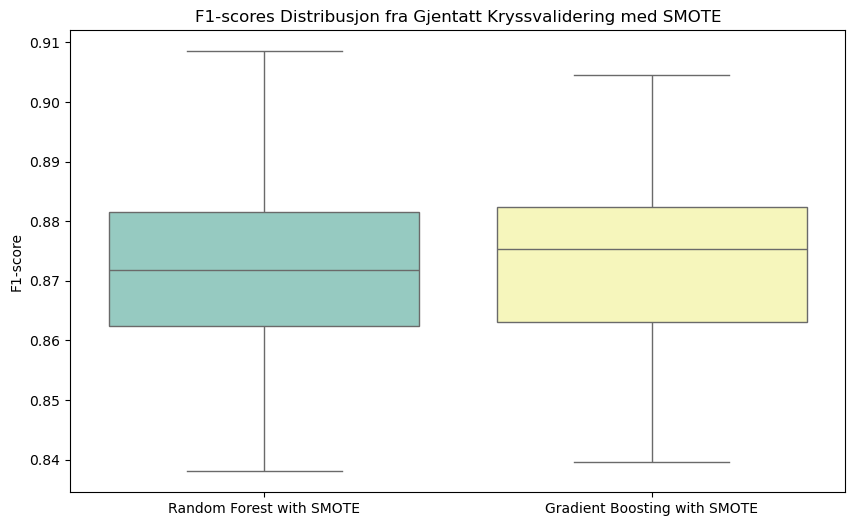


Statistisk sammenligning:
T-statistic: -0.5774
P-value: 0.5650

Ingen signifikant forskjell mellom modellene (p >= 0.05)


In [24]:
# Modifisert evaluate_models funksjon for å inkludere SMOTE
def evaluate_models_with_smote(X, y, model1, model2, model1_name, model2_name):
    
    # Oppsett for kryssvalidering
    rkf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)
    
    # Scoringfunksjoner for F1-score og nøyaktighet
    f1_scorer = make_scorer(f1_score, average='weighted')
    accuracy_scorer = make_scorer(accuracy_score)
    
    # Evaluerer modellene med kryssvalidering ved bruk av SMOTE for oppsampling
    scores = {}
    for name, model in [(model1_name, model1), (model2_name, model2)]:
        pipeline = Pipeline([
            ('smote', SMOTE(random_state=42)),
            ('model', model)
        ])
        scores[name] = {
            'f1': cross_val_score(pipeline, X, y, cv=rkf, scoring=f1_scorer, n_jobs=-1),
            'nøyaktighet': cross_val_score(pipeline, X, y, cv=rkf, scoring=accuracy_scorer, n_jobs=-1)
        }
    
    # Printer gjennomsnittlig F1-score og nøyaktighet for hver modell
    for name in scores:
        print(f"\n{name}:")
        print(f"Average F1-score: {scores[name]['f1'].mean():.3f} ± {scores[name]['f1'].std():.3f}")
        print(f"Average Accuracy: {scores[name]['nøyaktighet'].mean():.3f} ± {scores[name]['nøyaktighet'].std():.3f}")
    
    # Visualiserer F1-score distribusjon for begge modellene med boksplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=[scores[model1_name]['f1'], scores[model2_name]['f1']], palette="Set3")
    plt.xticks([0, 1], [model1_name, model2_name])
    plt.title('F1-scores Distribusjon fra Gjentatt Kryssvalidering med SMOTE')
    plt.ylabel('F1-score')
    plt.show()
    
    # Statistiske tester til sammenligning av modellene
    t_stat, p_value = ttest_ind(scores[model1_name]['f1'], scores[model2_name]['f1'])
    print("\nStatistisk sammenligning:")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Vurderer om det er signifikant forskjell mellom modellene
    if p_value < 0.05:
        better_model = model1_name if scores[model1_name]['f1'].mean() > scores[model2_name]['f1'].mean() else model2_name
        print(f"\nSignifikant forskjell oppdaget (p < 0.05)")
        print(f"{better_model} presterer betraktelig bedre")
    else:
        print("\nIngen signifikant forskjell mellom modellene (p >= 0.05)")

# Oppretter optimaliserte modeller med de beste parameterne fra hyperparametertuning i forrige oppgave
rf_optimized = RandomForestClassifier(random_state=42, **rf_best_params)
gb_optimized = GradientBoostingClassifier(random_state=42, **gb_best_params)

# Evaluerer og sammenligner modeller med SMOTE
evaluate_models_with_smote(X, y, rf_optimized, gb_optimized, 
                           "Random Forest with SMOTE", "Gradient Boosting with SMOTE")


**Svar:**

#### Tolkning av rsultater

- Etter balansering med SMOTE, ble forskjellene på modellene jevnet ut
- Random Forest og Gradient Boosting hadde henholdsvis 0.871 og 0.873 i F1-score
- Også liten forskjell i nøyaktighet, Random Forest (0.884) og Gradient Boosting 0.877
- p-verdi på 0.5831 idikerer at det ikke er noen signifikant forskjell mellom modellene

#### Sammenlikning med oppgave 2.2

- I oppgave 2.2 fant vi en signifikant forskjell mellom modellene, hvor Gradient Boosting utpekte seg
- Ved å balansere datasettet med SMOTE ser vi at dette ikke lenger er tilfelle
- Dette kan tyde på at forksjellen vi tidligere så i ytelse skyldtes ubalanse i datasettet.
- Begge modeller økte sin F1-score
  - Random Tree: 0.842 -> 0.871
  - Gradient Boosting: 0.867 -> 0.873
    - Balansering av datasettet bidro til en bedre klassifikasjonsevne, spesielt for Random Tree.

#### Oppgave 2.4)
Tren den beste modellen på nytt og utfør prediksjon på testsettet. Mål nå ytelsen på testsettet ved bruk av sensitivitet, spesifisitet og presisjon, itillegg til F1-skår og accuracy

In [27]:
#TODO: Tren den beste modellen fra 2.2 og 2.3 på alle treningsdataene og test på testdataene

In [28]:
# Tren den beste modellen på nytt (Gradient Boosting)
gb_optimized.fit(X_train, y_train)

# Utfører prediksjon på testsettet
y_pred = gb_optimized.predict(X_test)

# Beregner ytelsen
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')  # Sensitivitet
f1 = f1_score(y_test, y_pred, average='weighted')

# Beregner sensitivitet (Recall) og spesifisitet manuelt ved bruk av forvirringsmatrisen
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Spesifisitet = TN / (TN + FP)
specificity = tn / (tn + fp)

# Printer resultatene
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Sensitivitet (Recall): {recall:.3f}")
print(f"Spesifisitet: {specificity:.3f}")
print(f"F1-score: {f1:.3f}")

Accuracy: 0.888
Precision: 0.867
Sensitivitet (Recall): 0.888
Spesifisitet: 0.970
F1-score: 0.871


#### Oppgave 2.5)
Del opp testsettet basert på kjønn og gjør en analyse av sensitivitet, spesifisitet og presisjon for menn og det samme for kvinner. Skriv ut og diskuter resultatet og forsøk å svar på følgende spørsmål:
* Er modellen like god for begge kjønn? 
* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

In [30]:
#TODO: Gjør kjønnsbasert analyse på testdataene

In [31]:
def calculate_metrics(y_true, y_pred, label):
    """Beregner og skriver ut metrikker for en gitt gruppe."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() if confusion_matrix(y_true, y_pred).size == 4 else (0, 0, 0, 0)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivitet
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Spesifisitet
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\nResultater for {label}:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Presisjon: {precision:.3f}")
    print(f"Sensitivitet (Recall): {recall:.3f}")
    print(f"Spesifisitet: {specificity:.3f}")
    print(f"F1-skår: {f1:.3f}")

# Anta at 'Gender' er kodet som 0 for menn og 1 for kvinner (sjekk kodingen i ditt datasett)
male_value = 1
female_value = 0

# Del testsettet basert på kjønn
X_test_men = X_test[X_test['Gender'] == male_value]
y_test_men = y_test[X_test['Gender'] == male_value]

X_test_women = X_test[X_test['Gender'] == female_value]
y_test_women = y_test[X_test['Gender'] == female_value]

# Bruk samme modell som fra oppgave 2.4 
# Utfør prediksjon for menn
y_pred_men = gb_optimized.predict(X_test_men)
calculate_metrics(y_test_men, y_pred_men, label="Menn")

# Utfør prediksjon for kvinner
y_pred_women = gb_optimized.predict(X_test_women)
calculate_metrics(y_test_women, y_pred_women, label="Kvinner")



Resultater for Menn:
Accuracy: 0.904
Presisjon: 0.375
Sensitivitet (Recall): 0.214
Spesifisitet: 0.967
F1-skår: 0.273

Resultater for Kvinner:
Accuracy: 0.877
Presisjon: 0.647
Sensitivitet (Recall): 0.306
Spesifisitet: 0.972
F1-skår: 0.415


**Svar**

### Er modellen like god for begge kjønn?

**Accuracy:**
Modellen er noe mer nøyaktig på klassifisering for menn (0.904) enn kvinner (0.877)

**Presisjon:**
Modellen har en lavere presisjon from menn (0.375) enn for kvinner (0.647). Dette indikerer at modellen ofte feilklassifiserer tilfeller som er positive, spesielt hos menn.

**Sensitivitet:**
Det er lavere sensitivitet hos menn (0.214) enn hos kvinner (0.306). Dette kan tyde på at modellen strever med å identifisere faktiske positive tilfeller blant menn.

**Spesifisitet:**
Spesifisiteten er veldig lik for både menn (0.967) og kvinner (0.972). Dette viser at modellen er god til å fange opp faktiske negative tilfeller for begge grupper.

**F1-score:**
F1-scoren er langt bedre for kvinner (0.273) enn for menn (0.415). Dette bekrefter at modellen balanserer presisjon og sensitivitet bedre for kvinner enn for menn, noe vi har sett i resultatene.

Modellen er **ikke** like god for begge kjønn.

### Mulige årsaker

**Skjevhet i data:** En mulighet, og som også ofte er tilfelle i mange datasett, kan være en skjev fordeling hvor en gruppe ikke blir like godt representert. Modellen kan ha vanskeligheter for å generalisere dersom en gruppe er underrepresentert, og dette kan slå ut begge veier ved at resultatene kan se for gode ut, eller for dårlige. Derfor er det viktig å ha et balansert datasett i forhold til det man prøver å finne ut av.

**Bias:** Enkelte funksjoner i datasettet kan ha sterkere korrelasjoner med kjønn, som vil føre til skjeve prediksjoner.

**For enkel tilnærming:** Det er også godt mulig at modellen ikke er tilstrekkelig kompleks nok til å kunne klare å fange opp kjønnspesifikke mønstre.

### Tiltak for forbedring

**Balansere data:** Sørge for at datasettet er tilstrekkelig balansert og representerer begge kjønn godt. Vi var innom SMOTE som vi kunne jobber mye mer med, men vi kan også se på vekting av klasser f.eks.

**Vektet tapsfunksjon:** Vi kan bruke en modell med vektet tapsfunksjon som vil straffe feilklassifisering av den underrepresenterte klassen hardere, som potensielt kan gi bedre balanse.

**Separate modeller:** Kanskje utvikle separate modeller for menn/kvinner hvis det viser seg at de har svært forskjellig mønstre i dataen.

**Justere Hyperparametere:** Justere og tweake hyperparametere for modellen og se om det gir bedre resultater.

Kjør denne cellen til slutt og legg ved den genererte requirements.txt fila i pull requestet

In [54]:
!pip freeze > requirements.txt